# Config sử dụng GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Tải bộ chữ viết tay Mnist

In [ ]:
# Thêm thư viện để tại bộ data mnist
from keras.datasets.mnist import load_data
# Load bộ data vào bộ nhớ
(trainX, trainy), (testX, testy) = load_data()
# Thống kê lại dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

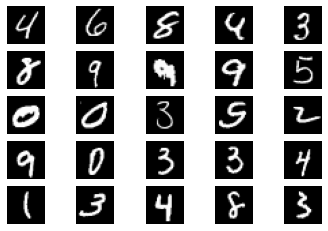

In [ ]:
import random
import numpy as np
from matplotlib import pyplot as plt
# Thêm số lượng ảnh cần hiển thị
LINES = 5
COLUMNS = 5
AMOUNT = LINES * COLUMNS
image = np.zeros((AMOUNT, 28, 28))
number = np.zeros(AMOUNT)
fig = plt.figure()

# Lấy ảnh random từ tập train ra
for i in range(AMOUNT):
    index = random.randint(0, trainy.shape[0])
    image[i] = trainX[index]
    number[i] = int(trainy[index])
    
# Tạo figure để chứa ảnh
for i in range(AMOUNT):
        ax = fig.add_subplot(LINES, COLUMNS, i + 1)
        plt.axis('off')
        plt.imshow(image[i], cmap='gray')
        plt.sca(ax)

# Hiển thị ảnh
# plt.xlabel(number)
plt.show()

# Định nghĩa các hàm bổ sung

In [ ]:
# Định nghĩa các hàm bổ sung
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot



# Load ảnh từ dataset
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# chuyển từ số nguyên qua số thực
	X = X.astype('float32')
	# chuyển từ [0, 255] qua [0, 1]
	X = X / 255.0
	return X

# Chọn ra dữ liệu huấn luyện 
def generate_real_samples(dataset, n_samples):
	# Chọn một index bất kì để lấy dataset 
	ix = randint(0, dataset.shape[0], n_samples)
	# Lấy ảnh từ index ra
	X = dataset[ix]
	# vì là ảnh thật -> label là real -> label là 1
	y = ones((n_samples, 1))
	return X, y


#  sinh ngẫu nhiên các điểm từ không gian ẩn
def generate_latent_points(latent_dim, n_samples):
	# sinh điểm ngẫu nhiên từ không gian ẩn
	x_input = randn(latent_dim * n_samples)
	# reshape để phù hợp vs input đầu vào của mạng
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# sinh ngẫu nhiên data giả với class label
def generate_fake_samples(g_model, latent_dim, n_samples):
	# sinh điểm ngẫu nhiên từ không gian ẩn
	x_input = generate_latent_points(latent_dim, n_samples)
	# tạo ra dữ liệu giả bằng model Generator
	X = g_model.predict(x_input)
	# Vì toàn bộ đều là dữ liệu giả nên label = 0 (False)
	y = zeros((n_samples, 1))
	return X, y

# Tạo và lưu các dữ liệu giả được tạo bởi Generator
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# định nghĩa các subplot
		pyplot.subplot(n, n, 1 + i)
		# tắt hiên thị các trục để ảnh nhìn cho đẹp
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# lưu plot lại thành file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()



# Khởi tạo Discriminator model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

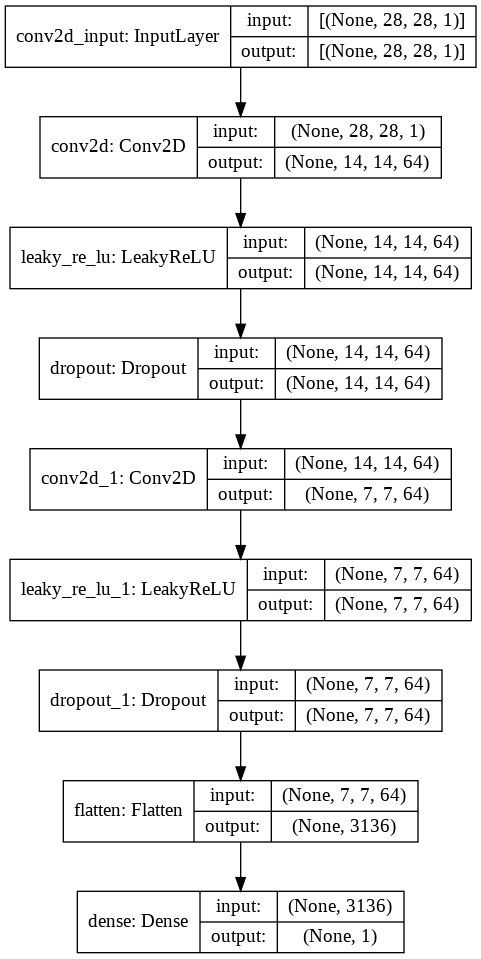

In [ ]:
# Import các thư viện
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# Định nghĩa các lớp có trong neural network
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# Thêm optimizer cho gradient descent
	opt = Adam(lr=0.0002, beta_1=0.5)
    # Compile model
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# Khởi tạo model
model = define_discriminator()
# Xuất ra các lớp có trong model
model.summary()
# Xuất ra các lớp trong model dưới dạng plot
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# Khởi tạo Generator model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

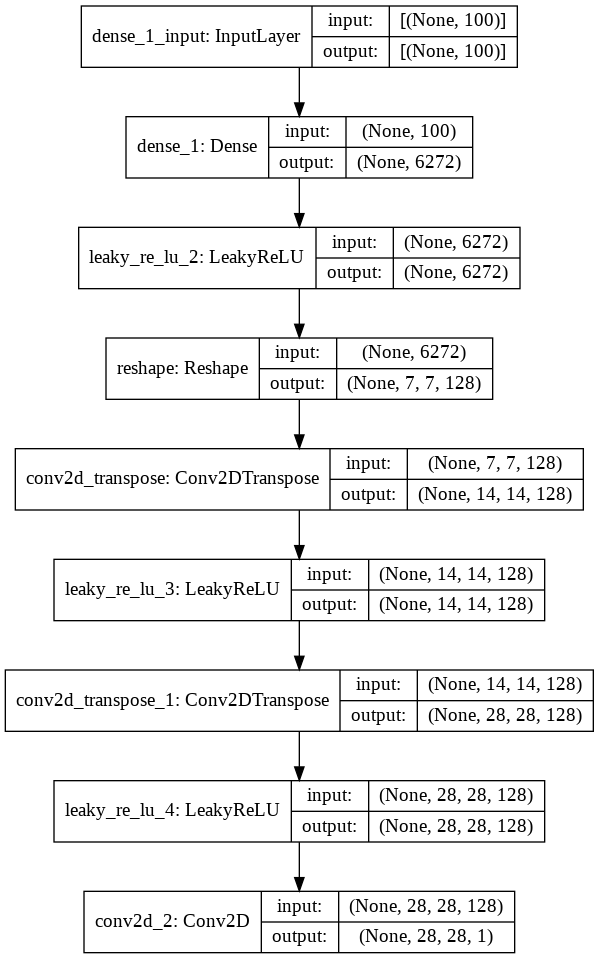

In [ ]:
# Khai báo các thư viện
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# Định nghĩa model Generator
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# Khởi tạo số chiều của latent space
latent_dim = 100
# Khởi tạo Generator
model = define_generator(latent_dim)
# Thống kê lại các lớp của model
model.summary()
# chuyển các số liệu thống kê trên thành ảnh
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# Khởi tạo mạng GANs


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


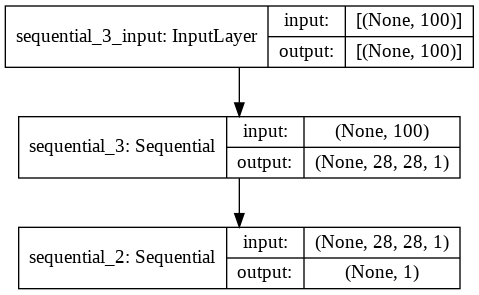

In [ ]:
# Import các thư viện
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

# Định nghĩa GANs model là tổng hợp của 2 model G và D
def define_gan(g_model, d_model):
	# khóa lại weight của discriminator
	d_model.trainable = False
	# khởi tạo model
	model = Sequential()
	# thêm generator vào model
	model.add(g_model)
	# thêm discriminator vào model
	model.add(d_model)
	# Thêm tối ưu cho gradient descent
	opt = Adam(lr=0.0002, beta_1=0.5)
    # Compile model
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# số chiều của không gian ẩn
latent_dim = 100
# khởi tạo discriminator
d_model = define_discriminator()
# Khởi tạo Generator
g_model = define_generator(latent_dim)
# Khởi tạo mạng Gans
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# lặp qua số lượng epochs
	for i in range(n_epochs):
		# Lặp qua tất cả các batch
		for j in range(bat_per_epo):
			# Lấy ngẫu nhiên các dữ liệu thật
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Tạo dữ liệu giả
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# tạo dữ liệu huấn luyện cho discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# cập nhật trọng số của discriminator
			d_loss, _ = d_model.train_on_batch(X, y)
			# tạo điểm trong không gian ẩn làm đầu vào cho generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# tạo label cho dữ liệu giả
			y_gan = ones((n_batch, 1))
			# cập nhật trọng số của Generator
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# tổng hợp loss của batch này
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

# Đánh giá


In [ ]:
# đánh giá độ chính xác và lưu lại model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# chuẩn bị dữ liệu thật
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# chạy discriminator trên dữ liệu thật
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# chuẩn bị dữ liệu giả
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# chạy discriminator trên dữ liệu giả
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# thống kê lại hiệu suất của discriminator 
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# Traning

In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# Lặp qua từng epoch
	for i in range(n_epochs):
		# Lặp qua từng batch
		for j in range(bat_per_epo):
			# lấy ngẫu nhiên các mẫu thật
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Tạo ra các mẫu giả
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# tạo tập dữ liệu huấn luyện cho discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# cập nhật trọng số của discriminator 
			d_loss, _ = d_model.train_on_batch(X, y)
			# tạo điểm nằm trong không gian ẩn
			X_gan = generate_latent_points(latent_dim, n_batch)
			# tạo label cho dữ liệu giả
			y_gan = ones((n_batch, 1))
			# cập nhật trọng số cho generator 
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# Thống kê hàm mất mát trong batch này
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# save lại model
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)# size of the latent space


In [ ]:
latent_dim = 100
# khởi tạo discriminator
d_model = define_discriminator()
# khởi tạo generator
g_model = define_generator(latent_dim)
# Khởi tạo GANs
gan_model = define_gan(g_model, d_model)
# load dữ liệu ảnh
dataset = load_real_samples()
# huấn luyện model
train(g_model, d_model, gan_model, dataset, latent_dim)

# Sinh dữ liệu giả bằng Generator

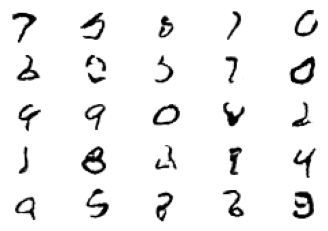

In [ ]:
# import các thư viện cần thiết
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# sinh điểm trong không gian ẩn
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# lưu ảnh lại
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# tạo điểm trong không gian ẩn
latent_points = generate_latent_points(100, 25)
# tạo ảnh giả
X = model.predict(latent_points)
# vẽ kết quả
save_plot(X, 5)